COINTERGRATION - LSTM - SP500

1. Import Library

In [112]:
#importing packages
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt
import bs4 as bs
import requests
import tensorflow as tf
from tensorflow.keras import layers
from IPython.display import clear_output
from scipy.stats import mstats
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RandomizedSearchCV, validation_curve, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import yfinance as yf
from ta.volume import MFIIndicator, OnBalanceVolumeIndicator
from ta.momentum import RSIIndicator, AwesomeOscillatorIndicator, StochasticOscillator
from ta.trend import MACD, CCIIndicator, SMAIndicator, EMAIndicator, ADXIndicator, WMAIndicator, AroonIndicator, VortexIndicator
from ta.volatility import AverageTrueRange, BollingerBands
import pickle
import os
from sklearn.model_selection import GridSearchCV
sns.set()

2. Import Data & Data Processing

In [113]:
#Import S&P500 as benchmark 
sp500 = yf.download('SPY', start='2016-01-01', end='2025-01-25')
sp500['return'] = np.log(sp500.Close/sp500.Close.shift(1))
sp500['cumreturn'] = sp500['return'].cumsum().apply(np.exp)
sp500.fillna(1, inplace=True)
sp500

[*********************100%***********************]  1 of 1 completed


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\yfinance\utils.py:689: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,Open,High,Low,Close,Adj Close,Volume,return,cumreturn
Date,,,,,,,,
2016-01-04,200.490005,201.029999,198.589996,201.020004,172.372894,222353500,1.000000,1.000000
2016-01-05,201.399994,201.899994,200.050003,201.360001,172.664413,110845800,0.001690,1.001691
2016-01-06,198.339996,200.059998,197.600006,198.820007,170.486404,152112600,-0.012694,0.989056
2016-01-07,195.330002,197.440002,193.589996,194.050003,166.396164,213436100,-0.024284,0.965327
2016-01-08,195.190002,195.850006,191.580002,191.919998,164.569687,209817200,-0.011037,0.954731
...,...,...,...,...,...,...,...,...
2025-01-17,596.960022,599.359985,595.609985,597.580017,597.580017,58070600,0.009990,2.972739
2025-01-21,600.669983,603.059998,598.669983,603.049988,603.049988,42532900,0.009112,2.999950
2025-01-22,605.919983,607.820007,605.359985,606.440002,606.440002,48196000,0.005606,3.016814


In [114]:
#Import data
df = pd.read_csv("top_50_sp500_data.csv", header=0, index_col=0, parse_dates=[0])
data = df.copy()
data = data.loc[data.index > '2004-08-11', :]
data
data

,Open,High,Low,Close,Adj Close,Volume,symbol,industry
Date,,,,,,,,
2004-08-12,0.086250,0.086500,0.083833,0.084000,0.077035,654384000,NVDA,Technology
2004-08-13,0.086000,0.088083,0.085250,0.087500,0.080245,815700000,NVDA,Technology
2004-08-16,0.086500,0.088833,0.086000,0.086667,0.079481,531732000,NVDA,Technology
2004-08-17,0.088583,0.091917,0.087750,0.091417,0.083837,744912000,NVDA,Technology
2004-08-18,0.091833,0.097500,0.091083,0.097500,0.089416,872424000,NVDA,Technology
...,...,...,...,...,...,...,...,...
2025-01-17,313.019989,315.399994,310.769989,312.559998,312.559998,2183500,AXP,Financials
2025-01-21,316.940002,319.700012,315.000000,317.950012,317.950012,2779100,AXP,Financials
2025-01-22,318.309998,322.820007,317.679993,322.250000,322.250000,2927400,AXP,Financials


In [115]:
#Top 50 companies based on market cap (26 Jan 2025)
top50 = pd.read_csv("top50companies.csv")
top50

,symbol
0,NVDA
1,AAPL
2,MSFT
3,AMZN
4,META
5,GOOGL
6,TSLA
7,AVGO
8,GOOG
9,BRK.B


In [116]:
contains_top50 = []
counter = 0
index = 0
while counter < 51 and index < len(top50):
    ticker = top50.iloc[index].symbol
    if ticker in data.symbol.unique():
        contains_top50.append(ticker)
        counter += 1
    index += 1
len(contains_top50)
data_top50 = data.loc[data.symbol.isin(contains_top50), :]
data_top50.loc[:, 'log_close'] = np.log(data_top50.Close)
data_top50

C:\Users\admin\AppData\Local\Temp\ipykernel_13968\2074902422.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_top50.loc[:, 'log_close'] = np.log(data_top50.Close)


,Open,High,Low,Close,Adj Close,Volume,symbol,industry,log_close
Date,,,,,,,,,
2004-08-12,0.086250,0.086500,0.083833,0.084000,0.077035,654384000,NVDA,Technology,-2.476938
2004-08-13,0.086000,0.088083,0.085250,0.087500,0.080245,815700000,NVDA,Technology,-2.436117
2004-08-16,0.086500,0.088833,0.086000,0.086667,0.079481,531732000,NVDA,Technology,-2.445682
2004-08-17,0.088583,0.091917,0.087750,0.091417,0.083837,744912000,NVDA,Technology,-2.392324
2004-08-18,0.091833,0.097500,0.091083,0.097500,0.089416,872424000,NVDA,Technology,-2.327903
...,...,...,...,...,...,...,...,...,...
2025-01-17,313.019989,315.399994,310.769989,312.559998,312.559998,2183500,AXP,Financials,5.744796
2025-01-21,316.940002,319.700012,315.000000,317.950012,317.950012,2779100,AXP,Financials,5.761894
2025-01-22,318.309998,322.820007,317.679993,322.250000,322.250000,2927400,AXP,Financials,5.775328


In [117]:
top50_df = pd.DataFrame()
for ticker in data_top50.symbol.unique():
    temp = data_top50.loc[data_top50.symbol==ticker, :]
    temp = temp.loc[(temp.index >= '2005-01-01') & (temp.index < '2015-01-01')]
    top50_df.loc[:, f'{ticker}'] = temp.loc[:, 'log_close']
top50_df

,NVDA,AAPL,MSFT,AMZN,META,GOOGL,TSLA,AVGO,GOOG,JPM,...,MCD,DIS,GS,AMD,CAT,PM,QCOM,ADBE,TXN,AXP
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,-1.627093,0.122376,3.286161,0.800206,NaN,1.623897,NaN,NaN,1.619156,3.667400,...,3.460095,3.313241,4.653484,3.063858,3.861466,NaN,3.745260,3.428975,3.185526,3.890555
2005-01-04,-1.675311,0.132594,3.289893,0.745265,NaN,1.582553,NaN,NaN,1.577811,3.648318,...,3.468233,3.302411,4.646984,3.006177,3.850360,NaN,3.740760,3.402197,3.161247,3.875416
2005-01-05,-1.666008,0.141314,3.287655,0.736446,NaN,1.577450,NaN,NaN,1.572709,3.650399,...,3.460409,3.296951,4.642466,2.983153,3.831030,NaN,3.745023,3.396687,3.130700,3.863911
2005-01-06,-1.675754,0.142089,3.286534,0.719059,NaN,1.551484,NaN,NaN,1.546743,3.656098,...,3.468233,3.298410,4.656148,2.981633,3.845670,NaN,3.761200,3.379974,3.126761,3.858754
2005-01-07,-1.695088,0.212371,3.283539,0.749527,NaN,1.579206,NaN,NaN,1.574464,3.648057,...,3.461665,3.288521,4.651863,2.991724,3.843530,NaN,3.766303,3.380654,3.132010,3.851341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24,-0.665046,3.332294,3.874113,2.718100,4.391606,3.290135,2.695798,2.309759,3.272080,4.134846,...,4.541485,4.547753,5.277553,0.974560,4.540312,4.420646,4.312945,4.314015,4.004784,4.544146
2014-12-26,-0.664074,3.349816,3.868698,2.737900,4.391729,3.298648,2.720506,2.308766,3.281978,4.135966,...,4.551558,4.554193,5.275305,0.974560,4.545739,4.422929,4.325721,4.313078,4.002777,4.546375
2014-12-29,-0.665532,3.349114,3.859677,2.747399,4.382277,3.290843,2.711201,2.315403,3.275025,4.142500,...,4.554298,4.559126,5.279084,0.978326,4.540205,4.421247,4.317355,4.305820,3.997466,4.546163


3. Cointegration Testing

In [118]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint


symbols = top50_df.columns

coint_results = pd.DataFrame(index=symbols, columns=symbols)

# Test cointegration for each pair of stocks
for i, stock1 in enumerate(symbols):
    for j, stock2 in enumerate(symbols):
        if i < j: 
            # Extract the price series for the two stocks
            series1 = top50_df[stock1].dropna()
            series2 = top50_df[stock2].dropna()

            # Align the series to ensure they have the same dates
            series1, series2 = series1.align(series2, join='inner')

            # Test for cointegration
            try:
                _, p_value, _ = coint(series1, series2)
            except:
                p_value = np.nan  # Handle cases where cointegration test fails

            # Store the p-value in the results matrix
            coint_results.loc[stock1, stock2] = p_value
            coint_results.loc[stock2, stock1] = p_value 

# Save the results to a CSV file
coint_results.to_csv("cointegration_results_all_pairs.csv")

# Display the results
print("Cointegration Test Results (p-values):")
print(coint_results)

Cointegration Test Results (p-values):
           NVDA      AAPL      MSFT      AMZN      META     GOOGL      TSLA  \
NVDA        NaN  0.264853  0.139108  0.228698  0.056491  0.255604  0.330669   
AAPL   0.264853       NaN  0.477204  0.007892  0.887474  0.591288  0.640818   
MSFT   0.139108  0.477204       NaN  0.745663  0.226945  0.217971  0.095898   
AMZN   0.228698  0.007892  0.745663       NaN  0.105196  0.369246  0.016387   
META   0.056491  0.887474  0.226945  0.105196       NaN  0.447937  0.605724   
GOOGL  0.255604  0.591288  0.217971  0.369246  0.447937       NaN  0.047777   
TSLA   0.330669  0.640818  0.095898  0.016387  0.605724  0.047777       NaN   
AVGO   0.248591  0.501531  0.385586  0.663482  0.172853  0.671741  0.675965   
GOOG   0.255912  0.624325  0.223986  0.360149  0.458692  0.087472  0.100449   
JPM    0.063673  0.675499  0.058884  0.725488  0.243535  0.045728  0.266916   
LLY    0.165825  0.909589   0.54961  0.952151  0.373619  0.373895  0.615172   
V      0.0742

First the best 10 pairs based on p-value

In [119]:
coint_results_unstacked = coint_results.unstack().dropna()

coint_results_unstacked = coint_results_unstacked[coint_results_unstacked.index.map(lambda x: x[0] < x[1])]

# Sort the pairs based on p-values and get the top 10
sorted_pairs = coint_results_unstacked.sort_values().head(10)

# Print the top 10 cointegrated pairs based on p-value
print("\nTop 10 Cointegrated Pairs based on p-value:")
for pair, p_value in sorted_pairs.items():
    print(f"{pair[0]}   {pair[1]}     {p_value:.6f}")


Top 10 Cointegrated Pairs based on p-value:
PEP   PG     0.000011
MRK   V     0.000037
CVX   KO     0.000122
MA   QCOM     0.000209
ADBE   JPM     0.000321
TXN   WFC     0.001012
MRK   WFC     0.001175
ADBE   MSFT     0.001286
ADBE   WFC     0.001596
MSFT   PEP     0.001619


Create coint_dic

In [120]:
top10_pairs = [
    ('PEP', 'PG', 0.000011),
    ('MRK', 'V', 0.000037),
    ('CVX', 'KO', 0.000122),
    ('MA', 'QCOM', 0.000209),
    ('ADBE', 'JPM', 0.000321),
    ('TXN', 'WFC', 0.001012),
    ('MRK', 'WFC', 0.001175),
    ('ADBE', 'MSFT', 0.001286),
    ('ADBE', 'WFC', 0.001596),
    ('MSFT', 'PEP', 0.001619)
]

# Create coint_dic
coint_dic = {}
for pair in top10_pairs:
    ticker1, ticker2, p_value = pair
    coint_dic[(ticker1, ticker2)] = p_value

# Display coint_dic
print("Cointegration Dictionary (coint_dic):")
print(coint_dic)

Cointegration Dictionary (coint_dic):
{('PEP', 'PG'): 1.1e-05, ('MRK', 'V'): 3.7e-05, ('CVX', 'KO'): 0.000122, ('MA', 'QCOM'): 0.000209, ('ADBE', 'JPM'): 0.000321, ('TXN', 'WFC'): 0.001012, ('MRK', 'WFC'): 0.001175, ('ADBE', 'MSFT'): 0.001286, ('ADBE', 'WFC'): 0.001596, ('MSFT', 'PEP'): 0.001619}


Creating TAs

In [121]:
def RSI(data, fast, slow):
    data['Diff'] = data['spread'].transform(lambda x: x.diff())
    data['Up'] = data['Diff']
    data.loc[(data['Up']<0), 'Up'] = 0

    data['Down'] = data['Diff']
    data.loc[(data['Down']>0), 'Down'] = 0 
    data['Down'] = abs(data['Down'])

    data['avg_fast_up'] = data['Up'].transform(lambda x: x.rolling(window=fast).mean())
    data['avg_fast_down'] = data['Down'].transform(lambda x: x.rolling(window=fast).mean())

    data['avg_slow_up'] = data['Up'].transform(lambda x: x.rolling(window=slow).mean())
    data['avg_slow_down'] = data['Down'].transform(lambda x: x.rolling(window=slow).mean())

    data['RS_fast'] = data['avg_fast_up'] / data['avg_fast_down']
    data['RS_slow'] = data['avg_slow_up'] / data['avg_slow_down']

    data['RSI_fast'] = 100 - (100/(1+data['RS_fast']))
    data['RSI_slow'] = 100 - (100/(1+data['RS_slow']))

    data['RSI_ratio'] = data['RSI_fast']/data['RSI_slow']

def SMA_ratio(data, fast, slow):
    data['SMA_ratio'] = data.spread.transform(lambda x: x.rolling(window=fast).mean())/data.spread.transform(lambda x: x.rolling(window=slow).mean())

def MACD(data, fast, slow):
    data['MACD'] = data['spread'].transform(lambda x: x.ewm(span=fast, adjust=False).mean()) - data['spread'].transform(lambda x: x.ewm(span=slow, adjust=False).mean())

In [122]:
def get_indicators(data, fast, slow):
    SMA_ratio(data, fast, slow)
    RSI(data, fast, slow)
    MACD(data, fast, slow)

In [123]:
indicators = ['SMA_ratio', 'RSI_ratio', 'spread', 'diff_spread', 'MACD']
lagged_indicators = []
lag = 30
for indicator in indicators:
    lagged_indicators.append(indicator)
    for i in range(1, lag):
        lagged_indicators.append(f'{indicator}_{i}')
lagged_indicators

['SMA_ratio',
 'SMA_ratio_1',
 'SMA_ratio_2',
 'SMA_ratio_3',
 'SMA_ratio_4',
 'SMA_ratio_5',
 'SMA_ratio_6',
 'SMA_ratio_7',
 'SMA_ratio_8',
 'SMA_ratio_9',
 'SMA_ratio_10',
 'SMA_ratio_11',
 'SMA_ratio_12',
 'SMA_ratio_13',
 'SMA_ratio_14',
 'SMA_ratio_15',
 'SMA_ratio_16',
 'SMA_ratio_17',
 'SMA_ratio_18',
 'SMA_ratio_19',
 'SMA_ratio_20',
 'SMA_ratio_21',
 'SMA_ratio_22',
 'SMA_ratio_23',
 'SMA_ratio_24',
 'SMA_ratio_25',
 'SMA_ratio_26',
 'SMA_ratio_27',
 'SMA_ratio_28',
 'SMA_ratio_29',
 'RSI_ratio',
 'RSI_ratio_1',
 'RSI_ratio_2',
 'RSI_ratio_3',
 'RSI_ratio_4',
 'RSI_ratio_5',
 'RSI_ratio_6',
 'RSI_ratio_7',
 'RSI_ratio_8',
 'RSI_ratio_9',
 'RSI_ratio_10',
 'RSI_ratio_11',
 'RSI_ratio_12',
 'RSI_ratio_13',
 'RSI_ratio_14',
 'RSI_ratio_15',
 'RSI_ratio_16',
 'RSI_ratio_17',
 'RSI_ratio_18',
 'RSI_ratio_19',
 'RSI_ratio_20',
 'RSI_ratio_21',
 'RSI_ratio_22',
 'RSI_ratio_23',
 'RSI_ratio_24',
 'RSI_ratio_25',
 'RSI_ratio_26',
 'RSI_ratio_27',
 'RSI_ratio_28',
 'RSI_ratio_29',
 'sp

In [124]:
def get_dataset(key, dic, train_val = True):
    temp = dic[key]
    temp = temp.iloc[:-lag, :] if train_val else temp
    x, y = temp.loc[:, lagged_indicators].to_numpy(), temp.loc[:, 'signal'].to_numpy()
    x_reshaped = np.array([np.transpose(row.reshape(5, 30)) for row in x])
    encoder = OneHotEncoder()
    y = encoder.fit_transform(y.reshape((-1, 1))).todense()
    return x_reshaped, y

In [125]:
coint_dic = { (key[0], key[1]): value for key, value in coint_dic.items() }

In [126]:
def plot_history(histories):
    fig, ax = plt.subplots(10, 2, figsize=(150,150))
    fig.tight_layout()
    metrics = ['accuracy', 'loss']
    for i in range(10):
        history = histories[i]
        for j in range(2):
            metric = metrics[j]
            ax[i,j].plot(history.history[f'{metric}'])
            ax[i,j].legend([f'train {metric}', f'{metric}'], loc='upper left')
            ax[i,j].set_title(f'cluster_{i}')
            ax[i,j].figure.set_size_inches(30,30)

4. LSTM training

In [127]:
train_dic = {}
test_dic = {}
volatility = 0.5
fast, slow = 5, 15

for ele in top10_pairs:
    ticker1, ticker2 = ele[:2]
    req_cols = ['Open', 'Close', 'symbol', 'log_close']
    temp1= data_top50.loc[data_top50.symbol==ticker1, req_cols]
    temp1.rename(columns={'Open': 'Open1',
                         'Close': 'Close1',
                         'symbol': 'symbol1',
                         'log_close': 'log_close1'}, inplace=True)
    temp2= data_top50.loc[data_top50.symbol==ticker2, req_cols]
    temp2.rename(columns={'Open': 'Open2',
                         'Close': 'Close2',
                         'symbol': 'symbol2',
                         'log_close': 'log_close2'}, inplace=True)
    temp = temp1.merge(temp2, on='Date', how='left')
    temp.loc[:, 'spread'] = temp.log_close1 - temp.log_close2
    temp.loc[:, 'spread_shifted'] = temp.spread.shift(-7)
    temp.loc[:, 'diff_spread'] = temp.spread - temp.spread_shifted
    temp.loc[:, 'diff_spread_std_pos'] = temp.loc[temp.diff_spread > 0, 'diff_spread'].rolling(lag).std() * volatility
    temp.loc[:, 'diff_spread_std_neg'] = temp.loc[temp.diff_spread < 0, 'diff_spread'].rolling(lag).std() * volatility
    temp.loc[:, 'signal'] = np.where((temp.diff_spread > 0) & (temp.diff_spread > temp.diff_spread_std_pos), -1, 0)
    temp.loc[:, 'signal'] = np.where((temp.diff_spread < 0) & (temp.diff_spread < -temp.diff_spread_std_neg), 1, temp.signal)
    
    get_indicators(temp, fast, slow)
    
    for indicator in indicators[:2]:
        indicator_lst = [indicator]
        for i in range(1, lag):
            temp.loc[:, f'{indicator}_{i}'] = temp.loc[:, f'{indicator}'].shift(i)
            indicator_lst.append(f'{indicator}_{i}')
        tempT = temp.loc[temp.index >= '2005-01-01', indicator_lst].transpose()
        scaler = MinMaxScaler(feature_range=(0, 1))
        temp.loc[temp.index >= '2005-01-01', indicator_lst] = scaler.fit_transform(tempT).transpose()
        
    for indicator in indicators[2:]:
        indicator_lst = [indicator]
        for i in range(1, lag):
            temp.loc[:, f'{indicator}_{i}'] = temp.loc[:, f'{indicator}'].shift(i)
            indicator_lst.append(f'{indicator}_{i}')
        tempT = temp.loc[temp.index >= '2005-01-01', indicator_lst].transpose()
        scaler = MinMaxScaler(feature_range=(-1, 1))
        temp.loc[temp.index >= '2005-01-01', indicator_lst] = scaler.fit_transform(tempT).transpose()
    
    train = temp.loc[(temp.index >= '2005-01-01') & (temp.index < '2016-01-01'), :]
    test = temp.loc[temp.index >= '2016-01-01', :]
    
    for df in [train, test]: 
        df.loc[:, 'Close1_shifted'] = df.Close1.shift(-lag + 1)
        df.loc[:, 'Close2_shifted'] = df.Close2.shift(-lag + 1)
        df.loc[:, 'Target1'] = ((df.Close1_shifted-df.Open1)/df.Open1).shift(-1)
        df.loc[:, 'Target2'] = ((df.Close2_shifted-df.Open2)/df.Open2).shift(-1)

    train_dic[(ticker1, ticker2)] = train
    test_dic[(ticker1, ticker2)] = test

C:\Users\admin\AppData\Local\Temp\ipykernel_13968\3791904893.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp.loc[:, f'{indicator}_{i}'] = temp.loc[:, f'{indicator}'].shift(i)
C:\Users\admin\AppData\Local\Temp\ipykernel_13968\3791904893.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp.loc[:, f'{indicator}_{i}'] = temp.loc[:, f'{indicator}'].shift(i)
C:\Users\admin\AppData\Local\Temp\ipykernel_13968\3791904893.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram

In [128]:
with open('train_dic.pkl', 'wb') as f:
    pickle.dump(train_dic, f)
    
with open('test_dic.pkl', 'wb') as f:
    pickle.dump(test_dic, f)    

In [129]:
train_df = pd.concat(list(train_dic.values()))
train_df = train_df.loc[:, ['symbol1', 'symbol2'] + lagged_indicators + ['diff_spread_std_pos', 'diff_spread_std_neg', 'signal']]
train_df

,symbol1,symbol2,SMA_ratio,SMA_ratio_1,SMA_ratio_2,SMA_ratio_3,SMA_ratio_4,SMA_ratio_5,SMA_ratio_6,SMA_ratio_7,...,MACD_23,MACD_24,MACD_25,MACD_26,MACD_27,MACD_28,MACD_29,diff_spread_std_pos,diff_spread_std_neg,signal
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,PEP,PG,0.043187,0.000000,0.025226,0.057236,0.135032,0.209046,0.182287,0.170060,...,-0.222071,0.003341,0.440660,0.190288,0.007258,-0.283434,-0.335956,NaN,0.009494,0
2005-01-04,PEP,PG,0.105011,0.043187,0.000000,0.025226,0.057236,0.135032,0.209046,0.182287,...,-0.420239,-0.222071,0.003341,0.440660,0.190288,0.007258,-0.283434,NaN,0.009578,0
2005-01-05,PEP,PG,0.239890,0.123751,0.050894,0.000000,0.029728,0.067450,0.159129,0.246351,...,-0.709442,-0.420239,-0.222071,0.003341,0.440660,0.190288,0.007258,NaN,0.009519,0
2005-01-06,PEP,PG,0.290394,0.267339,0.137910,0.056718,0.000000,0.033129,0.075168,0.177337,...,-0.820007,-0.709442,-0.420239,-0.222071,0.003341,0.440660,0.190288,NaN,0.009469,1
2005-01-07,PEP,PG,0.392109,0.290394,0.267339,0.137910,0.056718,0.000000,0.033129,0.075168,...,-0.520442,-0.820007,-0.709442,-0.420239,-0.222071,0.003341,0.440660,NaN,0.009399,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-24,MSFT,PEP,0.867130,0.804797,0.797225,0.747778,0.588820,0.507037,0.365812,0.301030,...,-0.407935,-0.467762,-0.200026,0.023910,0.384429,0.635298,1.000000,0.003723,NaN,-1
2015-12-28,MSFT,PEP,0.820398,0.851480,0.781804,0.773341,0.718069,0.540388,0.448971,0.291111,...,-0.450866,-0.275893,-0.349063,-0.021617,0.252261,0.693182,1.000000,0.004614,NaN,-1
2015-12-29,MSFT,PEP,0.813656,0.820398,0.851480,0.781804,0.773341,0.718069,0.540388,0.448971,...,-0.421456,-0.351358,-0.144679,-0.231108,0.155674,0.479181,1.000000,0.005137,NaN,-1


In [130]:
# Create a directory for saving models
model_dir = os.path.join(os.getcwd(), "models")
os.makedirs(model_dir, exist_ok=True)  # Ensure the directory exists

val_histories = []

# Loop through each pair in train_dic
for pair in train_dic.keys():
    ticker1, ticker2 = pair
    
    # Get the dataset for the current pair
    train_x, train_y = get_dataset(pair, train_dic)
    
    # Set random seed for reproducibility
    tf.random.set_seed(0)
    
    # Define the model
    inputs = layers.Input(shape=(30, 5), dtype=tf.float32)  
    x = layers.LSTM(128, activation='relu')(inputs)  
    output = layers.Dense(3, activation='softmax')(x)  # Output layer for 3 classes
    
    model = tf.keras.Model(inputs, output)
    
    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    
    # Train the model
    history = model.fit(train_x,
                        train_y,
                        epochs=15,
                        verbose=1,
                        )  
    
    # Append training history to val_histories
    val_histories.append(history)
    
    # Generate file path for saving the model
    file_loc = os.path.join(model_dir, f'pair_{ticker1}_{ticker2}_model.keras')  # Save with .keras extension
    
    # Save the model
    tf.keras.models.save_model(model, file_loc)
    
    print(f"Model for pair {ticker1}-{ticker2} saved at: {file_loc}")

Epoch 1/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.4288 - loss: 1.0704
Epoch 2/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.4738 - loss: 1.0441
Epoch 3/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4961 - loss: 1.0362
Epoch 4/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5399 - loss: 0.9813
Epoch 5/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5827 - loss: 0.9188
Epoch 6/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7416 - loss: 0.5945
Epoch 7/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8119 - loss: 0.4448
Epoch 8/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8382 - loss: 0.3921
Epoch 9/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8507 - loss: 0.3357
Epoch 10/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8692 - loss: 0.3124
Epoch 11/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8797 - loss: 0.2872
Epoch 12/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy:

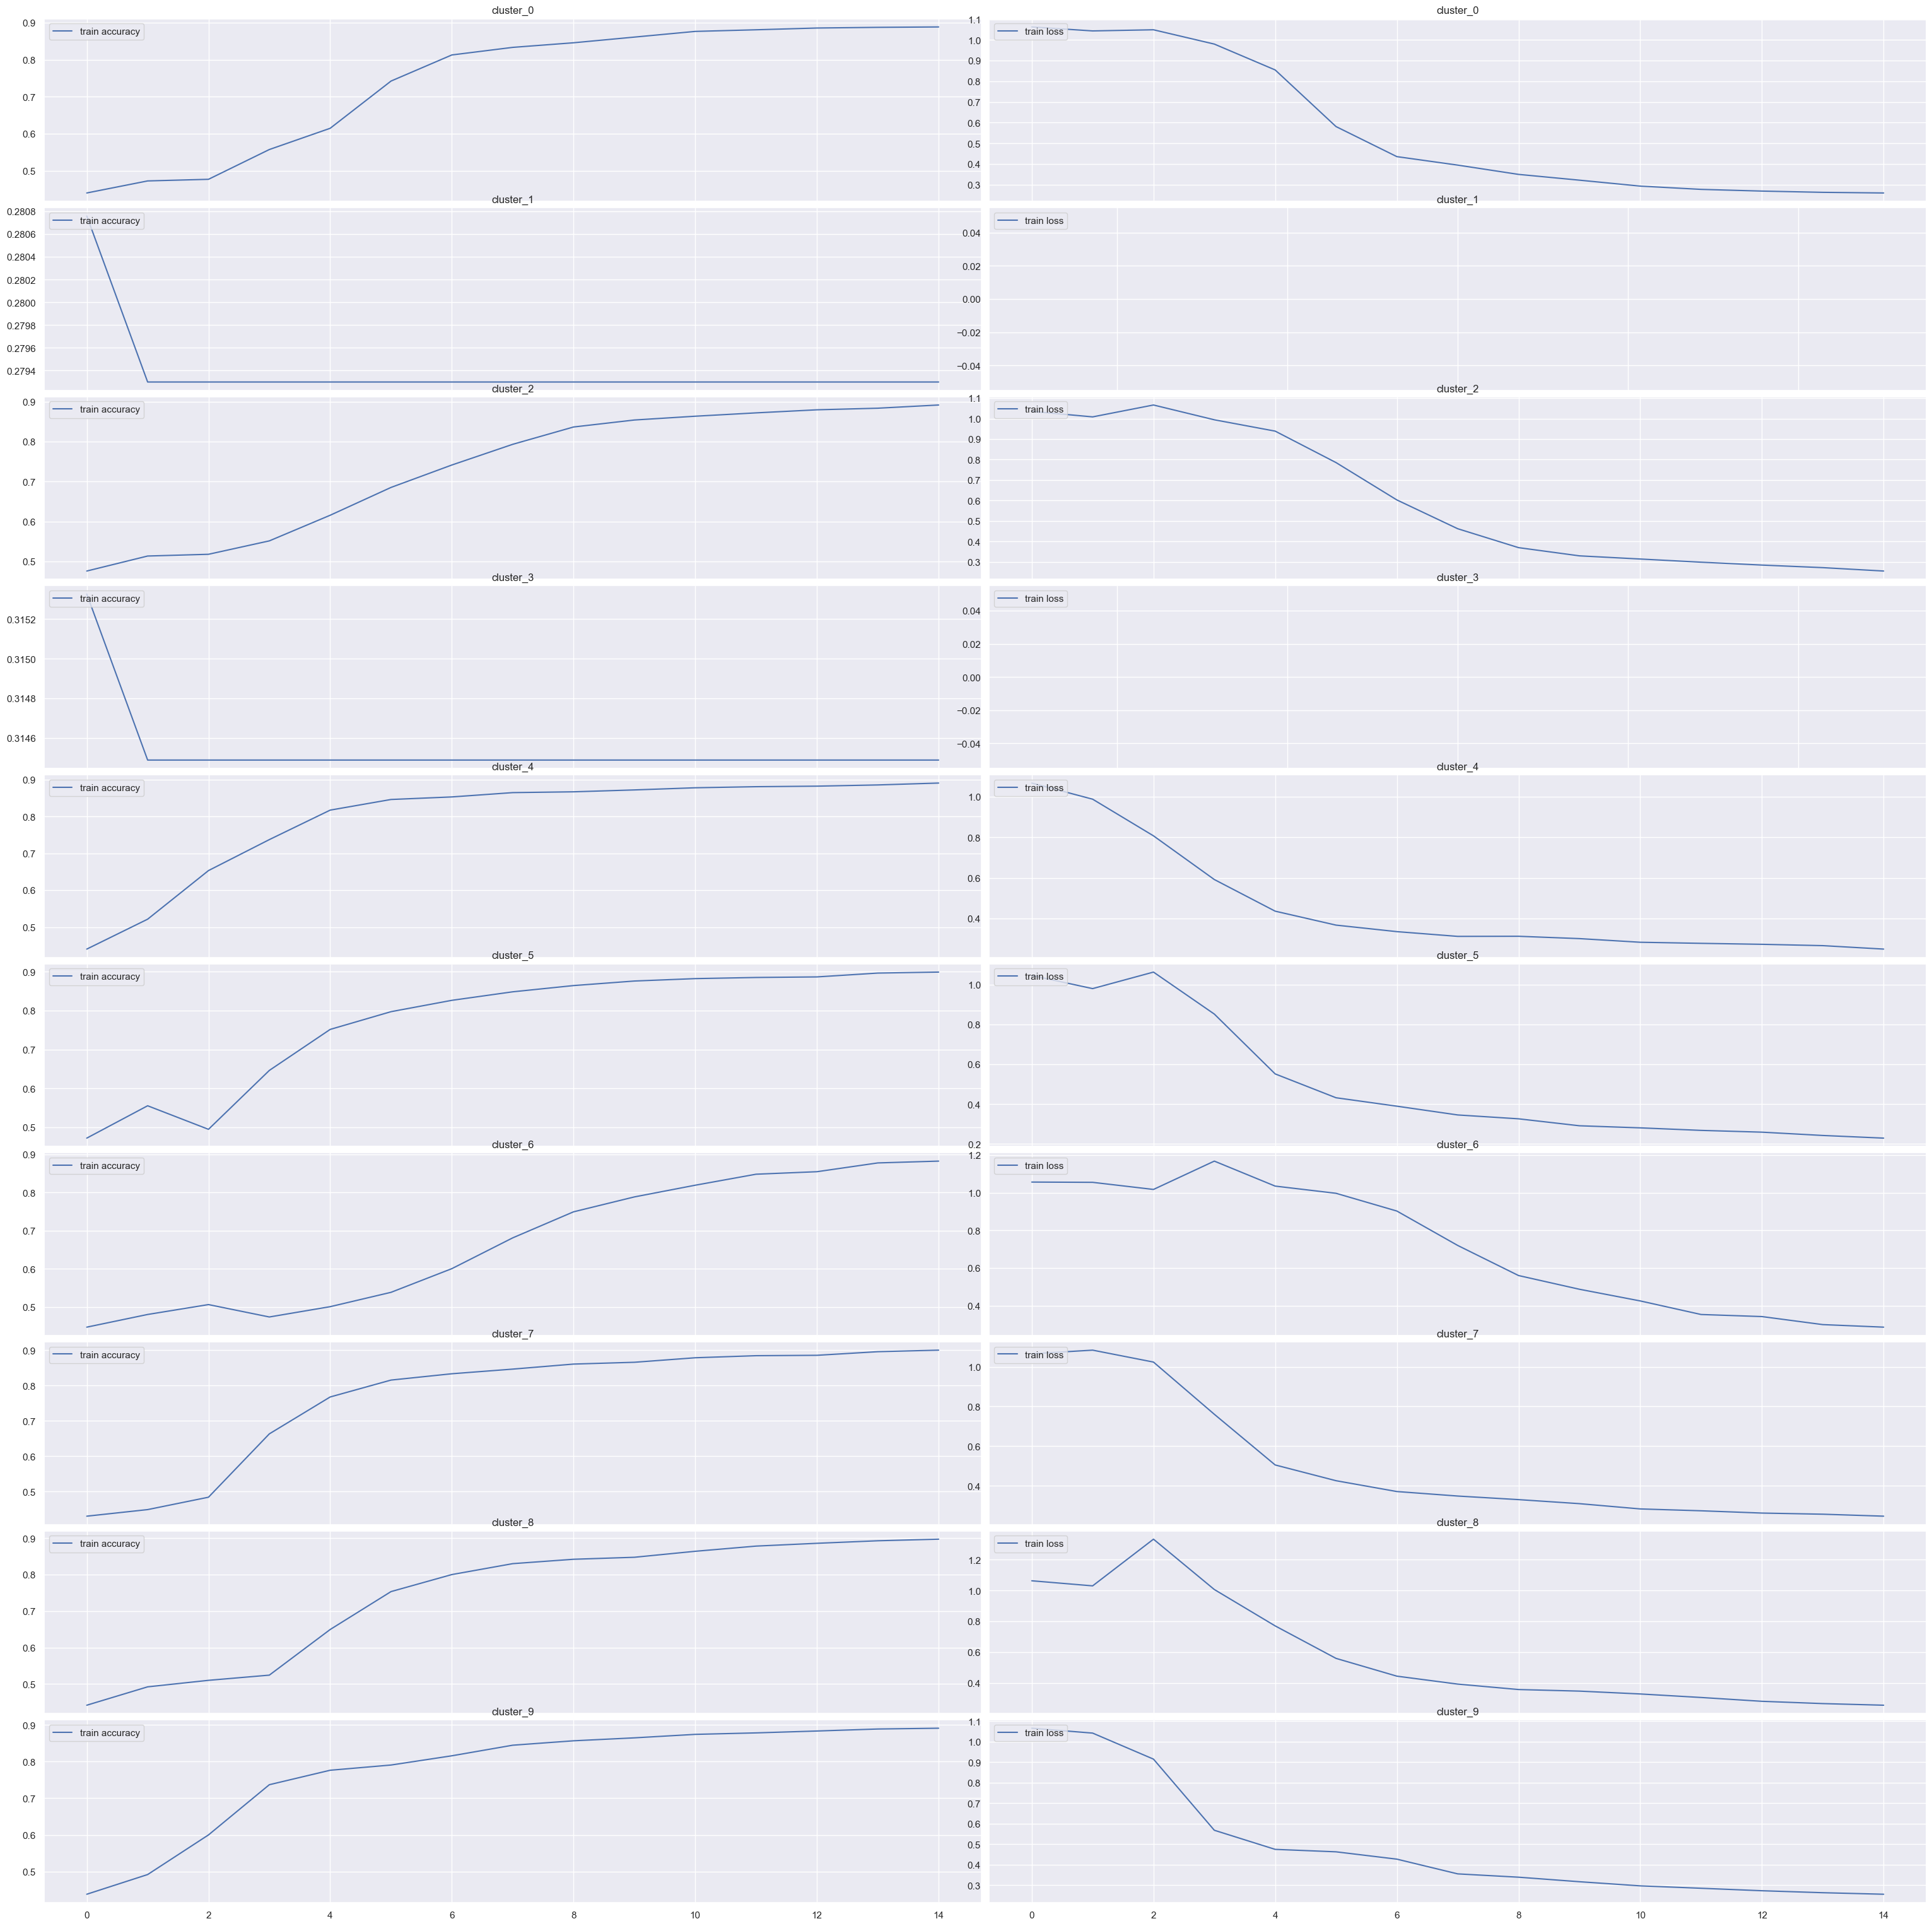

In [131]:
plot_history(val_histories)

5. Prediction


In [132]:
x, y = get_dataset(('PEP', 'PG'), test_dic, False)
model = tf.keras.models.load_model('pair_PEP_PG_model.keras')  # Forward slashes
preds = model.predict(x)
preds

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


array([[4.5126981e-05, 1.9591501e-01, 8.0403984e-01],
       [1.3107379e-01, 6.9373345e-01, 1.7519279e-01],
       [9.9996006e-01, 3.9984345e-05, 3.5804946e-20],
       ...,
       [          nan,           nan,           nan],
       [          nan,           nan,           nan],
       [          nan,           nan,           nan]], dtype=float32)

In [133]:
# Make predictions on test data

preds = []
sample_df = test_dic[list(test_dic.keys())[0]]

for pair in test_dic.keys():
    ticker1, ticker2 = pair
    tf.keras.backend.clear_session()
    testx, _ = get_dataset(pair, test_dic, False)
    model = tf.keras.models.load_model('pair_PEP_PG_model.keras')
    df = pd.DataFrame({'ticker1': [ticker1]*len(sample_df),
                      'ticker2': [ticker2]*len(sample_df),
                      'position': np.argmax(model.predict(testx), axis=1)-1})
    df.set_index(sample_df.index, inplace=True)
    preds.append(df)
preds_df = pd.concat(preds)
preds_df

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


,ticker1,ticker2,position
Date,,,
2016-01-04,PEP,PG,1
2016-01-05,PEP,PG,0
2016-01-06,PEP,PG,-1
2016-01-07,PEP,PG,-1
2016-01-08,PEP,PG,-1
...,...,...,...
2025-01-17,MSFT,PEP,-1
2025-01-21,MSFT,PEP,-1
2025-01-22,MSFT,PEP,-1


In [134]:
for i in range(len(preds_df.index.unique())):
    date = list(preds_df.index.unique())[i]
    if i%lag != 0:
        preds_df.loc[preds_df.index == date, 'position'] = 0
preds_df

,ticker1,ticker2,position
Date,,,
2016-01-04,PEP,PG,1
2016-01-05,PEP,PG,0
2016-01-06,PEP,PG,0
2016-01-07,PEP,PG,0
2016-01-08,PEP,PG,0
...,...,...,...
2025-01-17,MSFT,PEP,0
2025-01-21,MSFT,PEP,0
2025-01-22,MSFT,PEP,0


In [135]:
preds_df.position.value_counts()

position
 0    22186
 1      356
-1      248
Name: count, dtype: int64

In [136]:
preds_df.to_csv('preds.csv')
preds_df = pd.read_csv('preds.csv', header=0, index_col=0, parse_dates=[0])
preds_df

,ticker1,ticker2,position
Date,,,
2016-01-04,PEP,PG,1
2016-01-05,PEP,PG,0
2016-01-06,PEP,PG,0
2016-01-07,PEP,PG,0
2016-01-08,PEP,PG,0
...,...,...,...
2025-01-17,MSFT,PEP,0
2025-01-21,MSFT,PEP,0
2025-01-22,MSFT,PEP,0


In [137]:
test_df = pd.concat(list(test_dic.values()))
test_df = test_df.loc[:, ['symbol1', 'symbol2', 'diff_spread_std_pos', 'diff_spread_std_neg', 'Target1', 'Target2', 'signal']]
test_df

,symbol1,symbol2,diff_spread_std_pos,diff_spread_std_neg,Target1,Target2,signal
Date,,,,,,,
2016-01-04,PEP,PG,NaN,0.003738,0.007489,0.051122,1
2016-01-05,PEP,PG,0.007284,NaN,0.012604,0.055491,0
2016-01-06,PEP,PG,0.007116,NaN,0.011375,0.064281,-1
2016-01-07,PEP,PG,0.006883,NaN,0.020853,0.061660,-1
2016-01-08,PEP,PG,0.006880,NaN,0.022601,0.074045,-1
...,...,...,...,...,...,...,...
2025-01-17,MSFT,PEP,NaN,NaN,NaN,NaN,0
2025-01-21,MSFT,PEP,NaN,NaN,NaN,NaN,0
2025-01-22,MSFT,PEP,NaN,NaN,NaN,NaN,0


In [138]:
def get_pnl(x):
    if list(preds_df.index).index(x.index[0])%lag == 0:
        return (x['position']*x['Target1']-x['position']*x['Target2']).sum()/x['position'].abs().sum() + 1
    return 1
def merge_preds(test_df, preds_df):
    temp = pd.concat([preds_df, test_df.loc[:, ['signal', 'Target1', 'Target2']]], axis=1)
    temp.set_index(test_df.index, inplace=True)
    return temp
def strategy_return(merged_preds_df):
    strategies = pd.DataFrame()
    strategies['avg return'] = merged_preds_df.groupby('Date').apply(get_pnl).shift(lag).fillna(1)
    strategies['strategy'] = np.log(strategies['avg return'])
    strategies['cumstrategy'] = strategies['strategy'].cumsum().apply(np.exp)
    return strategies
test_preds = merge_preds(test_df, preds_df)
test_preds


,ticker1,ticker2,position,signal,Target1,Target2
Date,,,,,,
2016-01-04,PEP,PG,1,1,0.007489,0.051122
2016-01-05,PEP,PG,0,0,0.012604,0.055491
2016-01-06,PEP,PG,0,-1,0.011375,0.064281
2016-01-07,PEP,PG,0,-1,0.020853,0.061660
2016-01-08,PEP,PG,0,-1,0.022601,0.074045
...,...,...,...,...,...,...
2025-01-17,MSFT,PEP,0,0,NaN,NaN
2025-01-21,MSFT,PEP,0,0,NaN,NaN
2025-01-22,MSFT,PEP,0,0,NaN,NaN


In [139]:
test_preds = merge_preds(test_df, preds_df)
test_preds

,ticker1,ticker2,position,signal,Target1,Target2
Date,,,,,,
2016-01-04,PEP,PG,1,1,0.007489,0.051122
2016-01-05,PEP,PG,0,0,0.012604,0.055491
2016-01-06,PEP,PG,0,-1,0.011375,0.064281
2016-01-07,PEP,PG,0,-1,0.020853,0.061660
2016-01-08,PEP,PG,0,-1,0.022601,0.074045
...,...,...,...,...,...,...
2025-01-17,MSFT,PEP,0,0,NaN,NaN
2025-01-21,MSFT,PEP,0,0,NaN,NaN
2025-01-22,MSFT,PEP,0,0,NaN,NaN


6. Testing Strategies

In [140]:
test_strategies = strategy_return(test_preds)
test_strategies

,avg return,strategy,cumstrategy
Date,,,
2016-01-04,1.0,0.0,1.000000
2016-01-05,1.0,0.0,1.000000
2016-01-06,1.0,0.0,1.000000
2016-01-07,1.0,0.0,1.000000
2016-01-08,1.0,0.0,1.000000
...,...,...,...
2025-01-17,1.0,0.0,19.823571
2025-01-21,1.0,0.0,19.823571
2025-01-22,1.0,0.0,19.823571


In [141]:
test_strategies.loc[test_strategies.index < '2025-01-01', :]

,avg return,strategy,cumstrategy
Date,,,
2016-01-04,1.0,0.0,1.000000
2016-01-05,1.0,0.0,1.000000
2016-01-06,1.0,0.0,1.000000
2016-01-07,1.0,0.0,1.000000
2016-01-08,1.0,0.0,1.000000
...,...,...,...
2024-12-24,1.0,0.0,19.823571
2024-12-26,1.0,0.0,19.823571
2024-12-27,1.0,0.0,19.823571


In [171]:
num_reset_days = 0
corr_preds = []

for i in range(len(list(test_strategies.index)[:-lag])):
    if i%lag == 0:
        date = list(test_strategies.index)[i]
        temp = test_preds.loc[test_preds.index == date, ['position', 'signal']]
        corr_preds.append(np.sum(np.where(temp.position == temp.signal, 1, 0)))
        num_reset_days += 1
        
hit_rate = np.sum(np.asarray(corr_preds))/(num_reset_days*10)
hit_rate

np.float64(0.848)

In [172]:
for i in range(len(list(test_strategies.loc[test_strategies.index < '2025-01-01', :].index)[:-lag])):
    if i%lag == 0:
        date = list(test_strategies.index)[i]
        temp = test_preds.loc[test_preds.index == date, ['position', 'signal']]
        corr_preds.append(np.sum(np.where(temp.position == temp.signal, 1, 0)))
        num_reset_days += 1
        
hit_rate = np.sum(np.asarray(corr_preds))/(num_reset_days*10)
hit_rate

np.float64(0.848)

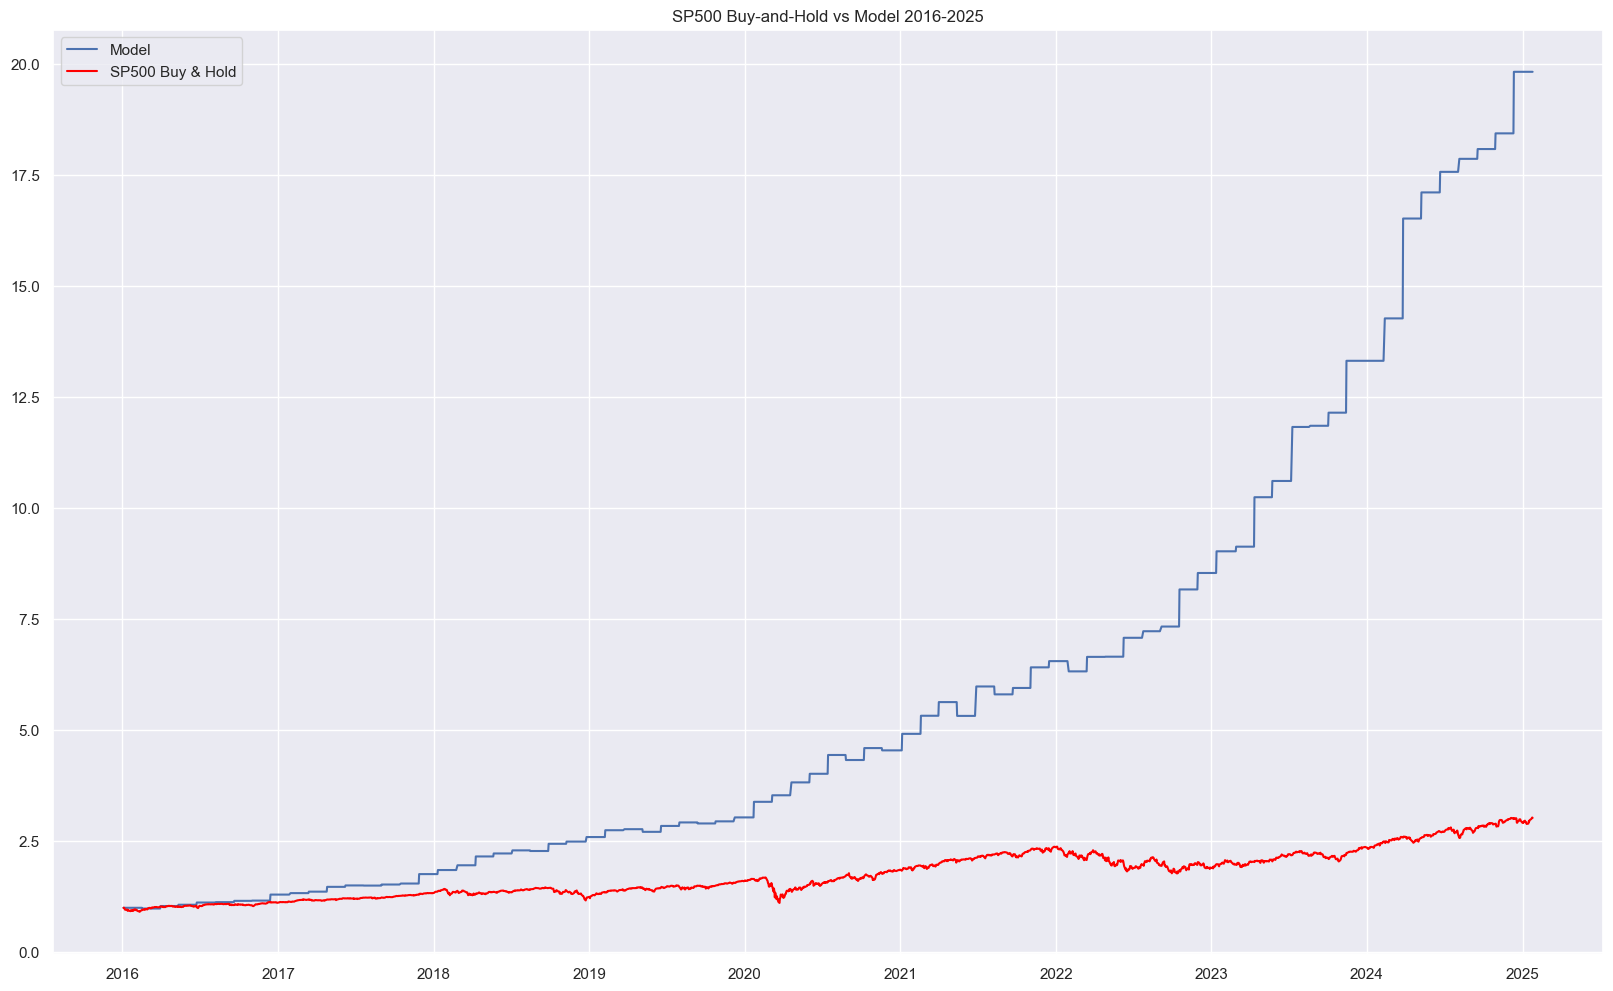

In [144]:
def plot_returns(benchmark, strategy, title):
    plt.figure(figsize=(20, 12))
    plt.plot(pd.to_datetime(strategy.index).date, strategy.cumstrategy, label='Model')
    plt.plot(benchmark.index, benchmark['cumreturn'], color='red', label='SP500 Buy & Hold')
    plt.title(title)
    plt.gca().grid(True)
    plt.legend()
plot_returns(sp500, test_strategies, 'SP500 Buy-and-Hold vs Model 2016-2025')

In [145]:
sp500_weekly = sp500.copy()
sp500_weekly['Close shifted'] = sp500_weekly.Close.shift(-lag+1)
sp500_weekly['Target'] = ((sp500_weekly['Close shifted']-sp500_weekly.Open)/sp500_weekly.Open).shift(-1)
sp500_weekly_return = []
for i in range(len(sp500_weekly)):
    if i%lag == 0:
        sp500_weekly_return.append(sp500_weekly.iloc[i]['Target'])
    else:
        sp500_weekly_return.append(0)
temp_df = pd.DataFrame({'return': sp500_weekly_return}).shift(lag)
temp_df =  temp_df.loc[temp_df['return'] != 0, 'return'].dropna()
sp500_sharpe = temp_df.mean()/temp_df.std()
sp500_sharpe

np.float64(0.38071848118608315)

In [146]:
sp500_weekly = sp500.loc[sp500.index < '2025-01-01', :]
sp500_weekly['Close shifted'] = sp500_weekly.Close.shift(-lag+1)
sp500_weekly['Target'] = ((sp500_weekly['Close shifted']-sp500_weekly.Open)/sp500_weekly.Open).shift(-1)
sp500_weekly_return = []
for i in range(len(sp500_weekly)):
    if i%lag == 0:
        sp500_weekly_return.append(sp500_weekly.iloc[i]['Target'])
    else:
        sp500_weekly_return.append(0)
temp_df = pd.DataFrame({'return': sp500_weekly_return}).shift(lag)
temp_df =  temp_df.loc[temp_df['return'] != 0, 'return'].dropna()
sp500_sharpe = temp_df.mean()/temp_df.std()
sp500_sharpe

C:\Users\admin\AppData\Local\Temp\ipykernel_13968\99552313.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_weekly['Close shifted'] = sp500_weekly.Close.shift(-lag+1)
C:\Users\admin\AppData\Local\Temp\ipykernel_13968\99552313.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_weekly['Target'] = ((sp500_weekly['Close shifted']-sp500_weekly.Open)/sp500_weekly.Open).shift(-1)


np.float64(0.38071848118608315)

In [147]:
strategy_weekly_return = test_strategies.loc[(test_strategies['avg return'] != 1) & (test_strategies.index < '2025-01-01'), 'avg return'] - 1
strategy_sharpe = strategy_weekly_return.mean()/strategy_weekly_return.std()
strategy_sharpe

np.float64(0.9501345692022709)

In [149]:

position_counts = preds_df['position'].value_counts()
num_long_trades = position_counts.get(1, 0)  # Number of long trades (position = 1)
num_short_trades = position_counts.get(-1, 0)  # Number of short trades (position = -1)
total_trades = num_long_trades + num_short_trades


if isinstance(preds_df.index, pd.DatetimeIndex):
    total_trading_days = len(preds_df.index.normalize().unique())  # Count unique dates
else:
    
    if 'date' in preds_df.columns:
        total_trading_days = len(preds_df['date'].unique())  # Count unique dates
    else:
        raise ValueError("No DateTime index or 'date' column found in preds_df.")

# Step 3: Calculate trades per day
trades_per_day = total_trades / total_trading_days

print(f"Total number of trades: {total_trades}")
print(f"Total number of trading days: {total_trading_days}")
print(f"Average trades per day: {trades_per_day:.2f}")

Total number of trades: 604
Total number of trading days: 2279
Average trades per day: 0.27


In [167]:
import numpy as np
import pandas as pd

# Assuming 'test_strategies' is your DataFrame
# Calculate total return
initial_value = test_strategies['cumstrategy'].iloc[0]
final_value = test_strategies['cumstrategy'].iloc[-1]
total_return = (final_value - initial_value) / initial_value

# Calculate annualized return
num_days = len(test_strategies)
num_years = num_days / 365.25  # Account for leap years
annualized_return = (final_value / initial_value) ** (1 / num_years) - 1

# Calculate average daily return
avg_daily_return = test_strategies['avg return'].mean()

# Calculate volatility (standard deviation of daily returns)
volatility = test_strategies['avg return'].std()

# Calculate Sharpe Ratio (assuming risk-free rate = 0)
risk_free_rate = 0  # Adjust this if you have a risk-free rate
sharpe_ratio = (avg_daily_return - risk_free_rate) / volatility



In [165]:

test_strategies['cummax'] = test_strategies['cumstrategy'].cummax()

# Step 2: Calculate the drawdown
test_strategies['drawdown'] = (test_strategies['cummax'] - test_strategies['cumstrategy']) / test_strategies['cummax']

# Step 3: Find the maximum drawdown
max_drawdown = test_strategies['drawdown'].max()



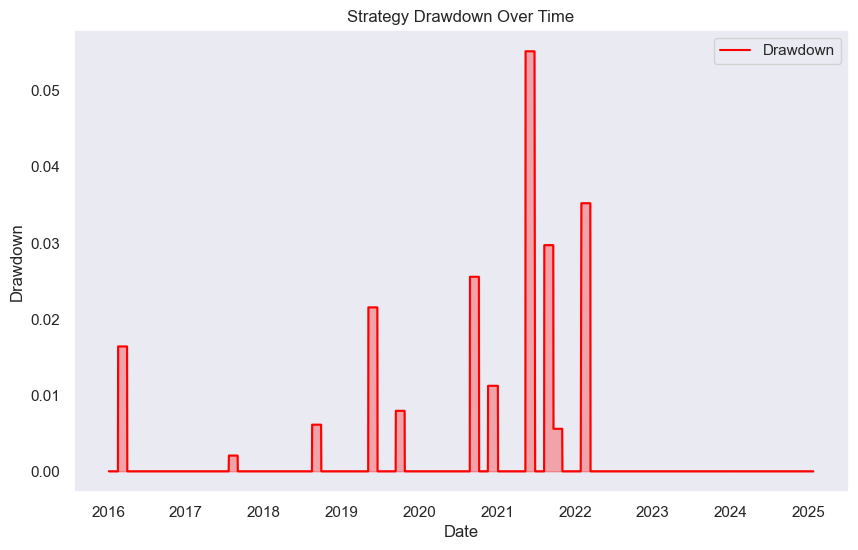

In [155]:
plt.figure(figsize=(10, 6))
plt.plot(test_strategies.index, test_strategies['drawdown'], label='Drawdown', color='red')
plt.fill_between(test_strategies.index, test_strategies['drawdown'], color='red', alpha=0.3)
plt.title('Strategy Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid()
plt.show()

In [170]:
initial_value = 1.0  # Initial value of cumstrategy
final_value = 19.823571  # Final value of cumstrategy
fee_percentage = 0.02  
num_years = 9  # Number of years

# Calculate total fees
total_fees = initial_value * fee_percentage * num_years

# Adjust final value for fees
after_fee_final_value = final_value - total_fees

# Calculate after-fee total return
after_fee_total_return = (after_fee_final_value / initial_value - 1) * 100

# Calculate after-fee annualized return
after_fee_annualized_return = (after_fee_final_value / initial_value) ** (1 / num_years) - 1

# Print results
print(f"Total Fees: {total_fees * 100:.2f}%")
print(f"After-Fee Final Value: {after_fee_final_value:.6f}")
print(f"After-Fee Total Return: {after_fee_total_return:.2f}%")
print(f"Annualized Return: {annualized_return * 100:.2f}%")
print(f"After-Fee Annualized Return: {after_fee_annualized_return * 100:.2f}%")
print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")
print(f"Total Return: {total_return * 100:.2f}%")
print(f"Average Daily Return: {avg_daily_return * 100:.4f}%")
print(f"Volatility (Standard Deviation of Returns): {volatility * 100:.4f}%")


Total Fees: 18.00%
After-Fee Final Value: 19.643571
After-Fee Total Return: 1864.36%
Annualized Return: 61.40%
After-Fee Annualized Return: 39.22%
Maximum Drawdown: 5.52%
Total Return: 1882.36%
Average Daily Return: 100.1367%
Volatility (Standard Deviation of Returns): 1.0814%


In [192]:

# Function to calculate metrics
def calculate_metrics(data, initial_value, fee_percentage, num_years):
    # Calculate daily returns
    data['Daily Return'] = data['Adj Close'].pct_change()
    
    # Calculate cumulative returns
    data['Cumulative Return'] = (1 + data['Daily Return']).cumprod()
    
    # Final value
    final_value = data['Cumulative Return'].iloc[-1] * initial_value
    
    # Total fees
    total_fees = initial_value * fee_percentage * num_years
    
    # After-fee final value
    after_fee_final_value = final_value - total_fees
    
    # After-fee total return
    after_fee_total_return = (after_fee_final_value / initial_value - 1) * 100
    
    # Annualized return
    annualized_return = (final_value / initial_value) ** (1 / num_years) - 1
    
    # After-fee annualized return
    after_fee_annualized_return = (after_fee_final_value / initial_value) ** (1 / num_years) - 1
    
    # Maximum drawdown
    data['Peak'] = data['Cumulative Return'].cummax()
    data['Drawdown'] = (data['Peak'] - data['Cumulative Return']) / data['Peak']
    max_drawdown = data['Drawdown'].max()
    
    # Total return
    total_return = (final_value / initial_value - 1) * 100
    
    # Average daily return
    avg_daily_return = data['Daily Return'].mean()
    
    # Volatility (standard deviation of returns)
    volatility = data['Daily Return'].std()
    
    # Print results
    print(f"Total Fees: {total_fees * 100:.2f}%")
    print(f"After-Fee Final Value: {after_fee_final_value:.6f}")
    print(f"After-Fee Total Return: {after_fee_total_return:.2f}%")
    print(f"Annualized Return: {annualized_return * 100:.2f}%")
    print(f"After-Fee Annualized Return: {after_fee_annualized_return * 100:.2f}%")
    print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Average Daily Return: {avg_daily_return * 100:.4f}%")
    print(f"Volatility (Standard Deviation of Returns): {volatility * 100:.4f}%")
    print("\n")

# Download S&P 500 data
ticker = "^GSPC"  # S&P 500 ticker
start_date_1 = "2016-01-01"
end_date_1 = "2020-12-31"
start_date_2 = "2016-01-01"
end_date_2 = "2025-01-25"

data_1 = yf.download(ticker, start=start_date_1, end=end_date_1)
data_2 = yf.download(ticker, start=start_date_2, end=end_date_2)

# Parameters
initial_value = 1.0
fee_percentage = 0.02
num_years_1 = 5  # Jan 2016 - Dec 2020
num_years_2 = 9  # Jan 2016 - Jan 25, 2025

# Calculate metrics for S&P 500 (Jan 2016 - Dec 2020)
print("S&P 500 Metrics (Jan 2016 - Dec 2020):")
calculate_metrics(data_1, initial_value, fee_percentage, num_years_1)

# Calculate metrics for S&P 500 (Jan 2016 - Jan 25, 2025)
print("S&P 500 Metrics (Jan 2016 - Jan 25, 2025):")
calculate_metrics(data_2, initial_value, fee_percentage, num_years_2)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
S&P 500 Metrics (Jan 2016 - Dec 2020):
Total Fees: 10.00%
After-Fee Final Value: 1.754282
After-Fee Total Return: 75.43%
Annualized Return: 13.14%
After-Fee Annualized Return: 11.90%
Maximum Drawdown: 33.92%
Total Return: 85.43%
Average Daily Return: 0.0565%
Volatility (Standard Deviation of Returns): 1.2115%


S&P 500 Metrics (Jan 2016 - Jan 25, 2025):
Total Fees: 18.00%
After-Fee Final Value: 2.851431
After-Fee Total Return: 185.14%
Annualized Return: 13.11%
After-Fee Annualized Return: 12.35%
Maximum Drawdown: 33.92%
Total Return: 203.14%
Average Daily Return: 0.0552%
Volatility (Standard Deviation of Returns): 1.1362%




C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\yfinance\utils.py:689: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\yfinance\utils.py:689: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [191]:
# Download S&P 500 data for 2016-2020
ticker = "^GSPC"  # S&P 500 ticker
start_date = "2016-01-01"
end_date = "2020-12-31"
data = yf.download(ticker, start=start_date, end=end_date)

# Calculate daily returns
data['Daily Return'] = data['Adj Close'].pct_change().dropna()

# Risk-free rate (annualized, e.g., 3-month Treasury bill rate)
risk_free_rate = 0.02  # 2% annualized, adjust as needed
risk_free_rate_daily = (1 + risk_free_rate) ** (1/252) - 1  # Convert to daily rate

# Calculate Sharpe Ratio
average_daily_return = data['Daily Return'].mean()
daily_volatility = data['Daily Return'].std()
sharpe_ratio = (average_daily_return - risk_free_rate_daily) / daily_volatility
annualized_sharpe_ratio = sharpe_ratio * np.sqrt(252)  # Annualize the Sharpe Ratio

# Calculate Hit Rate
positive_days = (data['Daily Return'] > 0).sum()
total_days = len(data['Daily Return'])
hit_rate = positive_days / total_days

# Print results
print(f"Sharpe Ratio (Annualized): {annualized_sharpe_ratio:.4f}")
print(f"Hit Rate: {hit_rate * 100:.2f}%")

# Download S&P 500 data
ticker = "^GSPC"  # S&P 500 ticker
start_date = "2016-01-01"
end_date = "2025-01-25"  # Adjust as needed
data = yf.download(ticker, start=start_date, end=end_date)

# Calculate daily returns
data['Daily Return'] = data['Adj Close'].pct_change().dropna()

# Risk-free rate (annualized, e.g., 3-month Treasury bill rate)
risk_free_rate = 0.02  # 2% annualized, adjust as needed
risk_free_rate_daily = (1 + risk_free_rate) ** (1/252) - 1  # Convert to daily rate

# Calculate Sharpe Ratio
average_daily_return = data['Daily Return'].mean()
daily_volatility = data['Daily Return'].std()
sharpe_ratio = (average_daily_return - risk_free_rate_daily) / daily_volatility
annualized_sharpe_ratio = sharpe_ratio * np.sqrt(252)  # Annualize the Sharpe Ratio

# Calculate Hit Rate
positive_days = (data['Daily Return'] > 0).sum()
total_days = len(data['Daily Return'])
hit_rate = positive_days / total_days

# Print results
print(f"Sharpe Ratio (Annualized): {annualized_sharpe_ratio:.4f}")
print(f"Hit Rate: {hit_rate * 100:.2f}%")

[*********************100%***********************]  1 of 1 completed
Sharpe Ratio (Annualized): 0.6376
Hit Rate: 55.64%
[*********************100%***********************]  1 of 1 completed
Sharpe Ratio (Annualized): 0.6611
Hit Rate: 54.50%


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\yfinance\utils.py:689: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\yfinance\utils.py:689: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [ ]:
# Function to calculate financial metrics with annual fee
def calculate_metrics(data, annual_fee_percentage=0.02):
    # Calculate total return (before fees)
    total_return = data['cumstrategy'].iloc[-1] / data['cumstrategy'].iloc[0] - 1
    
    # Calculate the annual fee adjustment
    fee_adjustment_factor = (1 - annual_fee_percentage) ** (len(data) / 252)
    after_fee_total_return = total_return * fee_adjustment_factor
    
    # Calculate average daily return
    avg_daily_return = data['avg return'].mean()

    # Calculate volatility (standard deviation of returns)
    daily_returns = data['cumstrategy'].pct_change().dropna()
    volatility = daily_returns.std()

    # Calculate maximum drawdown
    cum_returns = data['cumstrategy']
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    max_drawdown = drawdown.min()

    # Calculate annualized return
    total_days = len(data)
    annualized_return = (1 + total_return) ** (252 / total_days) - 1
    after_fee_annualized_return = (1 + after_fee_total_return) ** (252 / total_days) - 1

    # Calculate after-fee final value
    initial_value = 1  # Assuming we start with 1 unit of currency
    final_value = initial_value * (1 + after_fee_total_return)

    # Output the metrics
    metrics = {
        'Annual Fee': annual_fee_percentage * 100,
        'After-Fee Final Value': final_value,
        'After-Fee Total Return': after_fee_total_return * 100,
        'Annualized Return': annualized_return * 100,
        'After-Fee Annualized Return': after_fee_annualized_return * 100,
        'Maximum Drawdown': max_drawdown * 100,
        'Total Return': total_return * 100,
        'Average Daily Return': avg_daily_return * 100,
        'Volatility (Standard Deviation of Returns)': volatility * 100,
    }
    
    return metrics

# Filter data for Jan 2016 - Dec 2020
data_2016_2020 = test_strategies.loc['2016-01-01':'2020-12-31']

# Filter data for Jan 2016 - Jan 25, 2025
data_2016_2025 = test_strategies.loc['2016-01-01':'2025-01-25']

# Calculate metrics for both periods
metrics_2016_2020 = calculate_metrics(data_2016_2020)
metrics_2016_2025 = calculate_metrics(data_2016_2025)

# Print the results
print("Metrics for Jan 2016 - Dec 2020:")
for metric, value in metrics_2016_2020.items():
    print(f"{metric}: {value:.2f}%")

print("\nMetrics for Jan 2016 - Jan 25, 2025:")
for metric, value in metrics_2016_2025.items():
    print(f"{metric}: {value:.2f}%")


Metrics for Jan 2016 - Dec 2020:
Annual Fee: 2.00%
After-Fee Final Value: 4.20%
After-Fee Total Return: 320.43%
Annualized Return: 35.40%
After-Fee Annualized Return: 33.30%
Maximum Drawdown: -2.55%
Total Return: 354.46%
Average Daily Return: 100.12%
Volatility (Standard Deviation of Returns): 0.98%

Metrics for Jan 2016 - Jan 25, 2025:
Annual Fee: 2.00%
After-Fee Final Value: 16.68%
After-Fee Total Return: 1568.03%
Annualized Return: 39.13%
After-Fee Annualized Return: 36.50%
Maximum Drawdown: -5.52%
Total Return: 1882.36%
Average Daily Return: 100.14%
Volatility (Standard Deviation of Returns): 1.08%


7. Summary

In [210]:
data = {
    "Metric": [
        "Annual Fee", "After-Fee Total Return",
        "Annualized Return", "After-Fee Annualized Return", "Maximum Drawdown",
        "Total Return", "Average Daily Return", "Volatility (Standard Deviation of Returns)"
    ],
    "OurStrategy (Jan 2016 - Dec 2020)": [
        "2.00%", "320.43%", "35.40%", "33.30%", "-2.55%",
        "354.46%", "0.12%", "0.98%"
    ],
    "Our Strategy (Jan 2016 - Jan 25, 2025)": [
        "2.00%", "1568.03%", "39.13%", "36.50%", "-5.52%",
        "1882.36%", "0.14%", "1.08%"
    ],
    "S&P 500 (Jan 2016 - Dec 2020)": [
        "2.00%", "75.43%", "13.14%", "11.90%", "-33.92%",
        "85.43%", "0.0565%", "1.2115%"
    ],
    "S&P 500 (Jan 2016 - Jan 25, 2025)": [
        "2.00%", "185.14%", "13.11%", "12.35%", "-33.92%",
        "203.14%", "0.0552%", "1.1362%"
    ]
}

# Create DataFrame
metrics_df = pd.DataFrame(data)

# Display the table
metrics_df


,Metric,OurStrategy (Jan 2016 - Dec 2020),"Our Strategy (Jan 2016 - Jan 25, 2025)",S&P 500 (Jan 2016 - Dec 2020),"S&P 500 (Jan 2016 - Jan 25, 2025)"
0,Annual Fee,2.00%,2.00%,2.00%,2.00%
1,After-Fee Total Return,320.43%,1568.03%,75.43%,185.14%
2,Annualized Return,35.40%,39.13%,13.14%,13.11%
3,After-Fee Annualized Return,33.30%,36.50%,11.90%,12.35%
4,Maximum Drawdown,-2.55%,-5.52%,-33.92%,-33.92%
5,Total Return,354.46%,1882.36%,85.43%,203.14%
6,Average Daily Return,0.12%,0.14%,0.0565%,0.0552%
7,Volatility (Standard Deviation of Returns),0.98%,1.08%,1.2115%,1.1362%
